In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchmetrics
import torchvision as tv

import lightning as L
import matplotlib.pyplot as plt
import numpy as np

# Identical code as file `lightning-ai-demo-cpu.ipynb`. The only difference is the output. I'm running this Jupyter notebook on my Macbook Pro M2 with built-in GPU. Lightning (formerly named pytorch-lightning) will detect the GPU and use it if possible.

print("Using torch", torch.__version__)
print("Using lightning", L.__version__)

Using torch 2.5.0
Using lightning 2.4.0


Number of training samples: 55000
Number of validation samples: 4000
Number of test samples: 1000
Shape of image: torch.Size([1, 28, 28])
Label for this image: 3


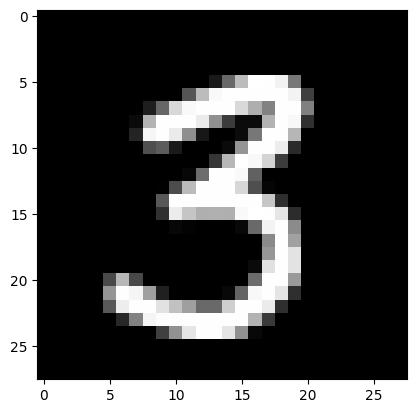

In [2]:
# --------------------
# Load Dataset - MNIST
# --------------------

# dataset: tuple[tensor of shape (N, R, C), label: int]
dataset = tv.datasets.MNIST(root=".", download=True, transform=tv.transforms.ToTensor())
train, val, test = data.random_split(dataset, [55000, 4000, 1000], torch.Generator().manual_seed(42))

# visualize
n = 44
image, label = train[n]
print(f"Number of training samples: {len(train)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of test samples: {len(test)}")
print(f"Shape of image: {image.shape}")
print(f"Label for this image: {label}")
plt.imshow(image.squeeze(), cmap="gray")

In [3]:
from IPython.display import Image
Image(url="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*uAeANQIOQPqWZnnuH-VEyw.jpeg")

In [4]:
# ------------
# Create Model
# ------------
class LeNetModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # 28 x 28 x 1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),

            # 28 x 28 x 6
            nn.MaxPool2d(kernel_size=2),

            # 14 x 14 x 6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),

            # 10 x 10 x 16
            nn.MaxPool2d(kernel_size=2),

            # 5 x 5 x 16
            nn.Flatten(),
            nn.Linear(in_features=5 * 5 * 16, out_features=120), 
            nn.ReLU(inplace=True),

            nn.Linear(in_features=120, out_features=84), 
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=10)
        )
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        print(x.shape)
        return self.encoder(x)

    def training_step(self, batch):
        loss = self._step(batch, step_type="train")
        return loss

    def validation_step(self, batch):
        loss = self._step(batch, step_type="val")
        return loss
    
    def _step(self, batch, step_type: str):
        images, labels = batch  # images: NxRxC
        
        # make predictions
        predictions = self.encoder(images)
        
        loss_fn = nn.CrossEntropyLoss()
        loss = loss_fn(predictions, labels)
        self.log(f"{step_type}_loss", loss)
        
        if step_type == "train":
            self.train_accuracy(predictions, labels)
            self.log(f"{step_type}_accuracy", self.train_accuracy)
        else:
            self.val_accuracy(predictions, labels)
            self.log(f"{step_type}_accuracy", self.val_accuracy)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [5]:
# -----------
# Train Model
# -----------
model = LeNetModel()
model.eval()

train_dataloader = data.DataLoader(
    dataset=train,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)
val_dataloader = data.DataLoader(
    dataset=val,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
)
trainer = L.Trainer(
    max_epochs=20,
    enable_progress_bar=False,
)
trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode
-------------------------------------------------------------
0 | encoder        | Sequential         | 61.7 K | eval
1 | train_accuracy | MulticlassAccuracy | 0      | eval
2 | val_accuracy   | MulticlassAccuracy | 0      | eval
-------------------------------------------------------------
61.7 K    Trainable params
0         Non-trainable params
61.7 K    Total params
0.247     Total estimated model params size (MB)
0         Modules in train mode
15        Modules in eval mode
`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# -------------
# Run Inference
# -------------
for n in [53, 54, 55]:
    image, label = test[n]
    softmax = nn.Softmax(dim=1)
    images = torch.stack((image, image), dim=0)
    pred = softmax(model.encoder(images)).detach().numpy().squeeze()
    # show
    plt.figure()
    plt.imshow(image.squeeze(), cmap="gray")
    print(label)
    print(["{0}:{1:.3%}".format(i, prob) for i, prob in enumerate(pred[0])])

In [ ]:
# tensorboard --logdir . 